### reference: 

In [1]:
import math
import torch
from torch.optim import Optimizer


class AdaBound(Optimizer):
    """Implements AdaBound algorithm.
    It has been proposed in `Adaptive Gradient Methods with Dynamic Bound of Learning Rate`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): Adam learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        final_lr (float, optional): final (SGD) learning rate (default: 0.1)
        gamma (float, optional): convergence speed of the bound functions (default: 1e-3)
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsbound (boolean, optional): whether to use the AMSBound variant of this algorithm
    .. Adaptive Gradient Methods with Dynamic Bound of Learning Rate:
        https://openreview.net/forum?id=Bkg3g2R9FX
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3,
                 eps=1e-8, weight_decay=0, amsbound=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))
        defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, eps=eps,
                        weight_decay=weight_decay, amsbound=amsbound)
        super(AdaBound, self).__init__(params, defaults)

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))

    def __setstate__(self, state):
        super(AdaBound, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsbound', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead')
                amsbound = group['amsbound']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsbound:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsbound:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsbound:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # Applies bounds on actual learning rate
                # lr_scheduler cannot affect final_lr, this is a workaround to apply lr decay
                final_lr = group['final_lr'] * group['lr'] / base_lr
                lower_bound = final_lr * (1 - 1 / (group['gamma'] * state['step'] + 1))
                upper_bound = final_lr * (1 + 1 / (group['gamma'] * state['step']))
                step_size = torch.full_like(denom, step_size)
                step_size.div_(denom).clamp_(lower_bound, upper_bound).mul_(exp_avg)

                p.data.add_(-step_size)

        return loss

class AdaBoundW(Optimizer):
    """Implements AdaBound algorithm with Decoupled Weight Decay (arxiv.org/abs/1711.05101)
    It has been proposed in `Adaptive Gradient Methods with Dynamic Bound of Learning Rate`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): Adam learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        final_lr (float, optional): final (SGD) learning rate (default: 0.1)
        gamma (float, optional): convergence speed of the bound functions (default: 1e-3)
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsbound (boolean, optional): whether to use the AMSBound variant of this algorithm
    .. Adaptive Gradient Methods with Dynamic Bound of Learning Rate:
        https://openreview.net/forum?id=Bkg3g2R9FX
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3,
                 eps=1e-8, weight_decay=0, amsbound=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))
        defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, eps=eps,
                        weight_decay=weight_decay, amsbound=amsbound)
        super(AdaBoundW, self).__init__(params, defaults)

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))

    def __setstate__(self, state):
        super(AdaBoundW, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsbound', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead')
                amsbound = group['amsbound']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsbound:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsbound:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsbound:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # Applies bounds on actual learning rate
                # lr_scheduler cannot affect final_lr, this is a workaround to apply lr decay
                final_lr = group['final_lr'] * group['lr'] / base_lr
                lower_bound = final_lr * (1 - 1 / (group['gamma'] * state['step'] + 1))
                upper_bound = final_lr * (1 + 1 / (group['gamma'] * state['step']))
                step_size = torch.full_like(denom, step_size)
                step_size.div_(denom).clamp_(lower_bound, upper_bound).mul_(exp_avg)

                if group['weight_decay'] != 0:
                    decayed_weights = torch.mul(p.data, group['weight_decay'])
                    p.data.add_(-step_size)
                    p.data.sub_(decayed_weights)
                else:
                    p.data.add_(-step_size)

        return loss

In [2]:
from functools import partial
from multiprocessing import Pool
import os
from pathlib import Path
import random
import shutil
import time
import xml.etree.ElementTree as ET

from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from scipy.stats import truncnorm
import torch
from torch import nn, optim
from torch.optim.optimizer import Optimizer
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.datasets.folder import default_loader
from torchvision.utils import save_image

In [3]:
start_time = time.time()

batch_size = 32
epochs = 300
seed = 1029

TRAIN_DIR = Path('../input/all-dogs/')
ANNOTATION_DIR = Path('../input/annotation/Annotation/')
DOG_DIR = Path('../dogs/dogs/')
OUT_DIR = Path('../output_images/')
DOG_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(exist_ok=True)

device = torch.device('cuda')

lr = 1e-3
beta1 = 0.9
nz = 128

real_label = 0.9
fake_label = 0.0

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
class Generator(nn.Module):
    
    def __init__(self, nz=128, channels=3):
        super(Generator, self).__init__()
        self.nz = nz
        self.channels = channels
        
        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
            ]
            return block

        self.model = nn.Sequential(
            *convlayer(self.nz, 1024, 4, 1, 0),
            *convlayer(1024, 512, 4, 2, 1),
            *convlayer(512, 256, 4, 2, 1),
            *convlayer(256, 128, 4, 2, 1),
            *convlayer(128, 64, 4, 2, 1),
            nn.ConvTranspose2d(64, self.channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(-1, self.nz, 1, 1)
        img = self.model(z)
        return img


class Discriminator(nn.Module):
    
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()
        self.channels = channels

        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, bn=False):
            block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
            if bn:
                block.append(nn.BatchNorm2d(n_output))
            block.append(nn.LeakyReLU(0.2, inplace=True))
            return block

        self.model = nn.Sequential(
            *convlayer(self.channels, 32, 4, 2, 1),
            *convlayer(32, 64, 4, 2, 1),
            *convlayer(64, 128, 4, 2, 1, bn=True),
            *convlayer(128, 256, 4, 2, 1, bn=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False)
        )

    def forward(self, imgs):
        out = self.model(imgs)
        return out.view(-1, 1)

In [5]:
class DogsDataset(Dataset):
    
    def __init__(self, root, annotation_root, transform=None,
                 target_transform=None, loader=default_loader, n_process=4):
        self.root = Path(root)
        self.annotation_root = Path(annotation_root)
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader
        self.imgs = self.cut_out_dogs(n_process)

    def _get_annotation_path(self, img_path):
        dog = Path(img_path).stem
        breed = dog.split('_')[0]
        breed_dir = next(self.annotation_root.glob(f'{breed}-*'))
        return breed_dir / dog
    
    @staticmethod
    def _get_dog_box(annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        objects = root.findall('object')
        for o in objects:
            bndbox = o.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            yield (xmin, ymin, xmax, ymax)
            
    def crop_dog(self, path):
        imgs = []
        annotation_path = self._get_annotation_path(path)
        for bndbox in self._get_dog_box(annotation_path):
            img = self.loader(path)
            img_ = img.crop(bndbox)
            if np.sum(img_) != 0:
                img = img_
            imgs.append(img)
        return imgs
                
    def cut_out_dogs(self, n_process):
        with Pool(n_process) as p:
            imgs = p.map(self.crop_dog, self.root.iterdir())
        return imgs
    
    def __getitem__(self, index):
        samples = random.choice(self.imgs[index])
        if self.transform is not None:
            samples = self.transform(samples)
        return samples
    
    def __len__(self):
        return len(self.imgs)

In [6]:
class ParamScheduler(object):
    
    def __init__(self, optimizer, scale_fn, step_size):
        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        
        self.optimizer = optimizer
        self.scale_fn = scale_fn
        self.step_size = step_size
        self.last_batch_iteration = 0
        
    def batch_step(self):
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.scale_fn(self.last_batch_iteration / self.step_size)
        
        self.last_batch_iteration += 1


def combine_scale_functions(scale_fns, phases=None):
    if phases is None:
        phases = [1. / len(scale_fns)] * len(scale_fns)
    phases = [phase / sum(phases) for phase in phases]
    phases = torch.tensor([0] + phases)
    phases = torch.cumsum(phases, 0)
    
    def _inner(x):
        idx = (x >= phases).nonzero().max()
        actual_x = (x - phases[idx]) / (phases[idx + 1] - phases[idx])
        return scale_fns[idx](actual_x)
        
    return _inner


def scale_cos(start, end, x):
    return start + (1 + np.cos(np.pi * (1 - x))) * (end - start) / 2

In [7]:
random_transforms = [transforms.RandomRotation(degrees=5)]
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.RandomHorizontalFlip(p=0.1),
                                transforms.RandomApply(random_transforms, p=0.1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = DogsDataset(TRAIN_DIR / 'all-dogs/', ANNOTATION_DIR, transform=transform)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=4)

imgs = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

net_g = Generator(nz).to(device)
net_d = Discriminator().to(device)

criterion = nn.BCELoss()
scale_fn = combine_scale_functions(
    [partial(scale_cos, 1e-5, 5e-4), partial(scale_cos, 5e-4, 1e-4)], [0.2, 0.8])

optimizer_g = AdaBound(net_g.parameters(), lr=lr, final_lr=0.5,betas=(beta1, 0.999))
optimizer_d = AdaBound(net_d.parameters(), lr=0.0005, final_lr=0.1,betas=(beta1, 0.999))

torch.backends.cudnn.benchmark = True

# optimizer_g = optim.Adam(net_g.parameters(), lr=lr, betas=(beta1, 0.999))
# optimizer_d = optim.Adam(net_d.parameters(), lr=lr, betas=(beta1, 0.999))

scheduler_g = ParamScheduler(optimizer_g, scale_fn, epochs * len(train_loader))
scheduler_d = ParamScheduler(optimizer_d, scale_fn, epochs * len(train_loader))

In [8]:
def truncated_normal(size, threshold=1):
    values = truncnorm.rvs(-threshold, threshold, size=size)
    return values

[1/300] Loss_d: 0.5083 Loss_g: 4.7463


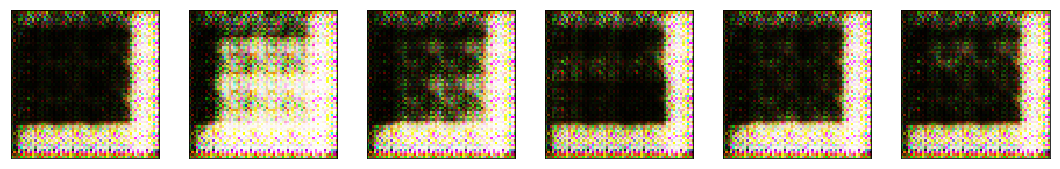

[2/300] Loss_d: 0.2071 Loss_g: 4.4970
[3/300] Loss_d: 0.2211 Loss_g: 2.3209
[4/300] Loss_d: 0.8189 Loss_g: 2.6341
[5/300] Loss_d: 0.0948 Loss_g: 3.0186
[6/300] Loss_d: 0.2591 Loss_g: 5.2108
[7/300] Loss_d: 1.7004 Loss_g: 1.3733
[8/300] Loss_d: 0.3301 Loss_g: 3.1749
[9/300] Loss_d: 2.1367 Loss_g: 2.9424
[10/300] Loss_d: 0.0335 Loss_g: 3.2759
[11/300] Loss_d: 0.8375 Loss_g: 4.8097
[12/300] Loss_d: 1.4968 Loss_g: 1.1310
[13/300] Loss_d: 0.0056 Loss_g: 3.1412
[14/300] Loss_d: 0.0365 Loss_g: 3.6183
[15/300] Loss_d: 0.5541 Loss_g: 2.7931
[16/300] Loss_d: 1.7819 Loss_g: 1.8091
[17/300] Loss_d: 0.0772 Loss_g: 3.7496
[18/300] Loss_d: 0.7687 Loss_g: 1.9381
[19/300] Loss_d: 0.1267 Loss_g: 2.9546
[20/300] Loss_d: 0.0617 Loss_g: 3.7476
[21/300] Loss_d: 0.3673 Loss_g: 2.3042
[22/300] Loss_d: 0.0921 Loss_g: 4.3790
[23/300] Loss_d: 1.3672 Loss_g: 2.6497
[24/300] Loss_d: 0.2331 Loss_g: 3.6039
[25/300] Loss_d: 0.9582 Loss_g: 1.3245
[26/300] Loss_d: 0.0054 Loss_g: 3.2075
[27/300] Loss_d: 0.2843 Loss_g: 2

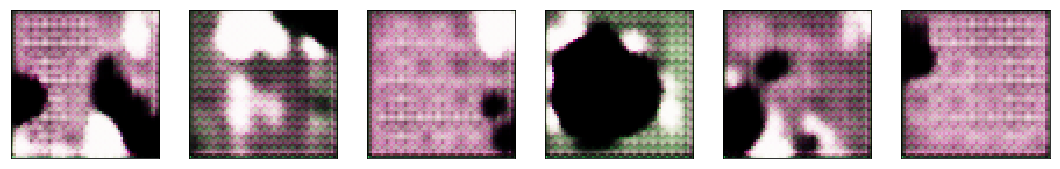

[32/300] Loss_d: 0.0876 Loss_g: 2.6595
[33/300] Loss_d: 0.0568 Loss_g: 3.6106
[34/300] Loss_d: 0.0211 Loss_g: 3.5790
[35/300] Loss_d: 0.0524 Loss_g: 3.4126
[36/300] Loss_d: 0.0299 Loss_g: 3.6172
[37/300] Loss_d: 0.0624 Loss_g: 2.6610
[38/300] Loss_d: 0.8970 Loss_g: 0.9971
[39/300] Loss_d: 0.0210 Loss_g: 2.5330
[40/300] Loss_d: 0.2046 Loss_g: 1.7199
[41/300] Loss_d: 0.4007 Loss_g: 1.6812
[42/300] Loss_d: 0.0624 Loss_g: 2.7329
[43/300] Loss_d: 0.3483 Loss_g: 2.1228
[44/300] Loss_d: 0.2123 Loss_g: 2.2159
[45/300] Loss_d: 0.0525 Loss_g: 2.5258
[46/300] Loss_d: 0.0256 Loss_g: 3.8122
[47/300] Loss_d: 0.0446 Loss_g: 2.7275
[48/300] Loss_d: 0.0805 Loss_g: 2.4842
[49/300] Loss_d: 0.0074 Loss_g: 3.1909
[50/300] Loss_d: 0.1483 Loss_g: 2.4976
[51/300] Loss_d: 0.0616 Loss_g: 2.9391
[52/300] Loss_d: 0.0995 Loss_g: 2.5157
[53/300] Loss_d: 0.0120 Loss_g: 2.9697
[54/300] Loss_d: 0.0009 Loss_g: 3.3249
[55/300] Loss_d: 0.2419 Loss_g: 1.8130
[56/300] Loss_d: 0.0017 Loss_g: 3.3804
[57/300] Loss_d: 0.7937 L

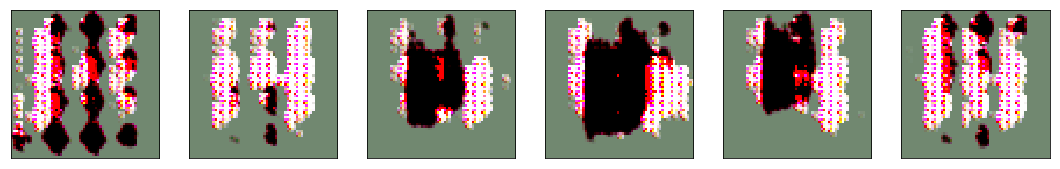

[62/300] Loss_d: 0.1686 Loss_g: 2.1713
[63/300] Loss_d: 0.0322 Loss_g: 3.0152
[64/300] Loss_d: 0.3030 Loss_g: 1.6549
[65/300] Loss_d: 0.2123 Loss_g: 1.9675
[66/300] Loss_d: 0.8689 Loss_g: 0.9229
[67/300] Loss_d: 0.3740 Loss_g: 1.6012
[68/300] Loss_d: 0.0952 Loss_g: 2.2792
[69/300] Loss_d: 0.0074 Loss_g: 2.9944
[70/300] Loss_d: 0.1642 Loss_g: 2.0120
[71/300] Loss_d: 0.0139 Loss_g: 3.6288
[72/300] Loss_d: 0.0426 Loss_g: 2.5822
[73/300] Loss_d: 0.0092 Loss_g: 2.9259
[74/300] Loss_d: 0.0325 Loss_g: 2.6500
[75/300] Loss_d: 0.0183 Loss_g: 2.7947
[76/300] Loss_d: 0.0054 Loss_g: 3.0003
[77/300] Loss_d: 0.0004 Loss_g: 3.2810
[78/300] Loss_d: 0.0002 Loss_g: 3.2836
[79/300] Loss_d: 0.0060 Loss_g: 2.9893
[80/300] Loss_d: 0.0322 Loss_g: 2.6923
[81/300] Loss_d: 0.0384 Loss_g: 3.3148
[82/300] Loss_d: 0.0506 Loss_g: 2.5807
[83/300] Loss_d: 0.1954 Loss_g: 2.0507
[84/300] Loss_d: 0.0061 Loss_g: 3.1715
[85/300] Loss_d: 0.3715 Loss_g: 1.5356
[86/300] Loss_d: 0.0463 Loss_g: 3.9346
[87/300] Loss_d: 0.0592 L

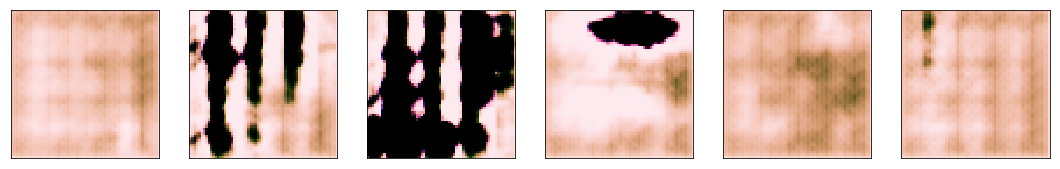

[92/300] Loss_d: 0.0759 Loss_g: 2.4897
[93/300] Loss_d: 0.0859 Loss_g: 2.3675
[94/300] Loss_d: 0.2991 Loss_g: 2.1244
[95/300] Loss_d: 0.1176 Loss_g: 2.1783
[96/300] Loss_d: 0.0411 Loss_g: 3.8982
[97/300] Loss_d: 0.0565 Loss_g: 2.8944
[98/300] Loss_d: 0.3464 Loss_g: 1.9551
[99/300] Loss_d: 0.1165 Loss_g: 2.2099
[100/300] Loss_d: 0.0333 Loss_g: 2.8103
[101/300] Loss_d: 0.0966 Loss_g: 4.4362
[102/300] Loss_d: 0.2057 Loss_g: 2.0532
[103/300] Loss_d: 0.0708 Loss_g: 2.4601
[104/300] Loss_d: 0.0052 Loss_g: 3.0448
[105/300] Loss_d: 0.0815 Loss_g: 2.3493
[106/300] Loss_d: 0.0023 Loss_g: 3.2917
[107/300] Loss_d: 0.0526 Loss_g: 2.5194
[108/300] Loss_d: 0.0514 Loss_g: 2.5923
[109/300] Loss_d: 0.0094 Loss_g: 3.0436
[110/300] Loss_d: 0.0533 Loss_g: 2.5005
[111/300] Loss_d: 0.0921 Loss_g: 2.2390
[112/300] Loss_d: 0.0343 Loss_g: 2.9171
[113/300] Loss_d: 0.1099 Loss_g: 2.3353
[114/300] Loss_d: 0.0369 Loss_g: 2.6486
[115/300] Loss_d: 0.0049 Loss_g: 3.4958
[116/300] Loss_d: 0.0050 Loss_g: 3.0779
[117/300

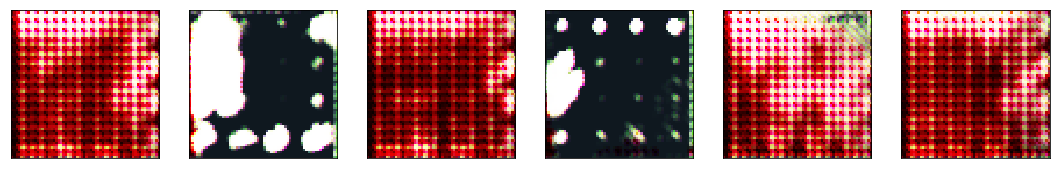

[122/300] Loss_d: 0.1708 Loss_g: 2.0704
[123/300] Loss_d: 0.1884 Loss_g: 2.1165
[124/300] Loss_d: 0.0810 Loss_g: 2.5990
[125/300] Loss_d: 0.1481 Loss_g: 2.1522
[126/300] Loss_d: 0.0284 Loss_g: 2.6793
[127/300] Loss_d: 0.0002 Loss_g: 3.1956
[128/300] Loss_d: 0.1554 Loss_g: 2.0060
[129/300] Loss_d: 0.0192 Loss_g: 2.7693
[130/300] Loss_d: 0.0298 Loss_g: 2.6790
[131/300] Loss_d: 0.0977 Loss_g: 2.2568
[132/300] Loss_d: 0.1906 Loss_g: 1.8980
[133/300] Loss_d: 0.0001 Loss_g: 3.2560
[134/300] Loss_d: 0.0005 Loss_g: 3.2293
[135/300] Loss_d: 0.0200 Loss_g: 2.7624
[136/300] Loss_d: 0.0003 Loss_g: 3.2067
[137/300] Loss_d: 0.1933 Loss_g: 4.5572
[138/300] Loss_d: 0.0229 Loss_g: 3.3517
[139/300] Loss_d: 0.5208 Loss_g: 1.2240
[140/300] Loss_d: 0.3867 Loss_g: 1.7497
[141/300] Loss_d: 0.1957 Loss_g: 2.0311
[142/300] Loss_d: 0.0796 Loss_g: 2.3558
[143/300] Loss_d: 0.0255 Loss_g: 3.1905
[144/300] Loss_d: 0.0073 Loss_g: 3.3885
[145/300] Loss_d: 0.2347 Loss_g: 1.8381
[146/300] Loss_d: 0.2841 Loss_g: 1.7377


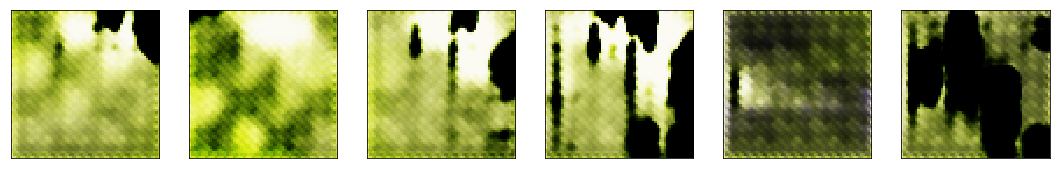

[152/300] Loss_d: 1.1943 Loss_g: 0.6290
[153/300] Loss_d: 0.1788 Loss_g: 2.0451
[154/300] Loss_d: 0.1217 Loss_g: 2.2176
[155/300] Loss_d: 0.5950 Loss_g: 1.1254
[156/300] Loss_d: 0.6326 Loss_g: 1.3337
[157/300] Loss_d: 0.0865 Loss_g: 2.2120
[158/300] Loss_d: 0.1558 Loss_g: 2.2471
[159/300] Loss_d: 0.4047 Loss_g: 1.4157
[160/300] Loss_d: 0.1866 Loss_g: 1.9847
[161/300] Loss_d: 0.0440 Loss_g: 3.8498
[162/300] Loss_d: 0.4233 Loss_g: 1.3416
[163/300] Loss_d: 0.1423 Loss_g: 2.1479
[164/300] Loss_d: 0.1731 Loss_g: 2.0401
[165/300] Loss_d: 0.5684 Loss_g: 1.2108
[166/300] Loss_d: 0.0197 Loss_g: 2.8496
[167/300] Loss_d: 0.3596 Loss_g: 1.5943
[168/300] Loss_d: 1.2204 Loss_g: 0.6186
[169/300] Loss_d: 0.7016 Loss_g: 1.2235
[170/300] Loss_d: 0.1333 Loss_g: 2.2560
[171/300] Loss_d: 0.0353 Loss_g: 2.7588
[172/300] Loss_d: 0.8253 Loss_g: 0.9048
[173/300] Loss_d: 0.0234 Loss_g: 2.9238
[174/300] Loss_d: 0.2061 Loss_g: 1.8727
[175/300] Loss_d: 0.3941 Loss_g: 1.4336
[176/300] Loss_d: 1.0744 Loss_g: 0.6707


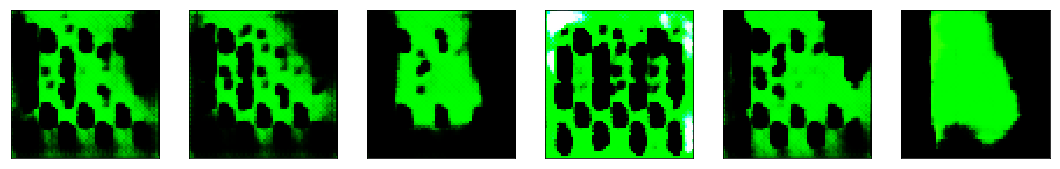

[182/300] Loss_d: 0.3016 Loss_g: 1.6172
[183/300] Loss_d: 0.3365 Loss_g: 1.5199
[184/300] Loss_d: 0.1514 Loss_g: 2.0483
[185/300] Loss_d: 0.0195 Loss_g: 2.7871
[186/300] Loss_d: 0.0589 Loss_g: 2.4466
[187/300] Loss_d: 0.0234 Loss_g: 2.7426
[188/300] Loss_d: 0.0123 Loss_g: 2.8967
[189/300] Loss_d: 0.0160 Loss_g: 3.4495
[190/300] Loss_d: 0.1936 Loss_g: 1.9126
[191/300] Loss_d: 0.4244 Loss_g: 1.5691
[192/300] Loss_d: 1.2006 Loss_g: 0.7258
[193/300] Loss_d: 0.0522 Loss_g: 2.7529
[194/300] Loss_d: 0.3093 Loss_g: 5.2917
[195/300] Loss_d: 0.2994 Loss_g: 1.6155
[196/300] Loss_d: 0.0165 Loss_g: 2.8055
[197/300] Loss_d: 0.0143 Loss_g: 3.6538
[198/300] Loss_d: 0.0847 Loss_g: 2.3131
[199/300] Loss_d: 0.1198 Loss_g: 2.1946
[200/300] Loss_d: 0.0901 Loss_g: 2.2848
[201/300] Loss_d: 0.0148 Loss_g: 2.8415
[202/300] Loss_d: 0.0851 Loss_g: 2.3051
[203/300] Loss_d: 0.0031 Loss_g: 3.0713
[204/300] Loss_d: 0.0028 Loss_g: 3.3498
[205/300] Loss_d: 0.0078 Loss_g: 3.5339
[206/300] Loss_d: 0.0037 Loss_g: 3.0429


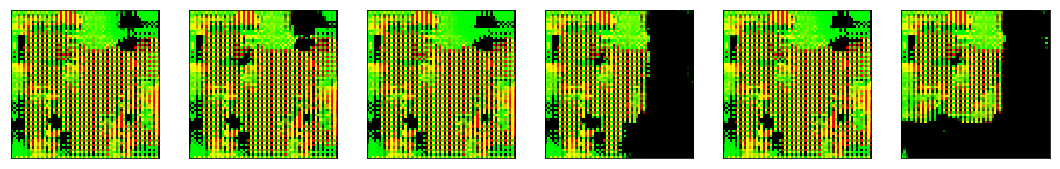

[212/300] Loss_d: 0.0008 Loss_g: 3.2807
[213/300] Loss_d: 0.0101 Loss_g: 2.9121
[214/300] Loss_d: 0.0198 Loss_g: 2.7742
[215/300] Loss_d: 0.0179 Loss_g: 3.6989
[216/300] Loss_d: 0.0009 Loss_g: 3.3335
[217/300] Loss_d: 0.0099 Loss_g: 2.9124
[218/300] Loss_d: 0.0145 Loss_g: 2.8324
[219/300] Loss_d: 0.0458 Loss_g: 2.5332
[220/300] Loss_d: 0.0416 Loss_g: 2.5682
[221/300] Loss_d: 0.0152 Loss_g: 3.6758
[222/300] Loss_d: 0.0323 Loss_g: 3.8847
[223/300] Loss_d: 0.0022 Loss_g: 3.4011
[224/300] Loss_d: 0.0661 Loss_g: 2.4028
[225/300] Loss_d: 0.0005 Loss_g: 3.2321
[226/300] Loss_d: 0.0013 Loss_g: 3.1298
[227/300] Loss_d: 0.0037 Loss_g: 3.4479
[228/300] Loss_d: 0.0127 Loss_g: 2.8697
[229/300] Loss_d: 0.1081 Loss_g: 2.1889
[230/300] Loss_d: 0.0224 Loss_g: 2.7409
[231/300] Loss_d: 0.0004 Loss_g: 3.1962
[232/300] Loss_d: 0.0024 Loss_g: 3.1683
[233/300] Loss_d: 0.0274 Loss_g: 3.8294
[234/300] Loss_d: 0.0015 Loss_g: 3.1697
[235/300] Loss_d: 0.0067 Loss_g: 3.5265
[236/300] Loss_d: 0.0005 Loss_g: 3.2351


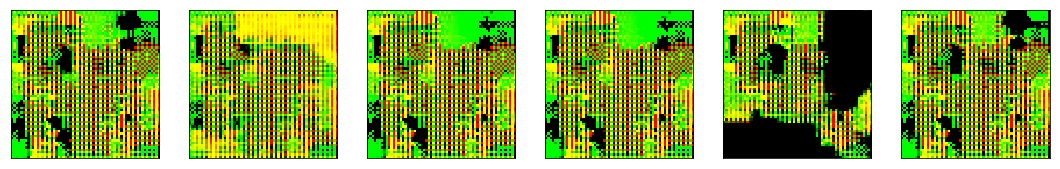

[242/300] Loss_d: 0.0013 Loss_g: 3.3261
[243/300] Loss_d: 0.0008 Loss_g: 3.2883
[244/300] Loss_d: 0.0964 Loss_g: 2.2388
[245/300] Loss_d: 0.0378 Loss_g: 2.6016
[246/300] Loss_d: 0.0008 Loss_g: 3.1649
[247/300] Loss_d: 0.0184 Loss_g: 2.7791
[248/300] Loss_d: 0.0014 Loss_g: 3.3508
[249/300] Loss_d: 0.6610 Loss_g: 1.0747
[250/300] Loss_d: 0.3103 Loss_g: 1.6425
[251/300] Loss_d: 0.2928 Loss_g: 5.3715
[252/300] Loss_d: 0.7125 Loss_g: 1.0103
[253/300] Loss_d: 0.9456 Loss_g: 0.7484
[254/300] Loss_d: 0.4040 Loss_g: 1.4309
[255/300] Loss_d: 0.0455 Loss_g: 2.5915
[256/300] Loss_d: 0.8830 Loss_g: 0.9345
[257/300] Loss_d: 0.3011 Loss_g: 1.6151
[258/300] Loss_d: 0.7329 Loss_g: 0.9268
[259/300] Loss_d: 0.3297 Loss_g: 1.5926
[260/300] Loss_d: 0.4504 Loss_g: 1.5310
[261/300] Loss_d: 0.5972 Loss_g: 1.2302
[262/300] Loss_d: 0.0481 Loss_g: 2.6685
[263/300] Loss_d: 0.0849 Loss_g: 2.4812
[264/300] Loss_d: 0.4185 Loss_g: 1.4003
[265/300] Loss_d: 0.0983 Loss_g: 4.3492
[266/300] Loss_d: 0.0586 Loss_g: 4.2069


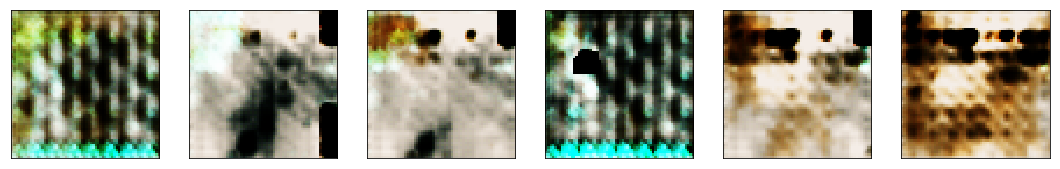

[272/300] Loss_d: 1.3850 Loss_g: 0.4904
[273/300] Loss_d: 0.9016 Loss_g: 0.8174
[274/300] Loss_d: 0.0156 Loss_g: 2.8711
[275/300] Loss_d: 0.2933 Loss_g: 1.6453
[276/300] Loss_d: 0.3678 Loss_g: 1.4836
[277/300] Loss_d: 0.0687 Loss_g: 4.1993
[278/300] Loss_d: 0.5420 Loss_g: 1.2201
[279/300] Loss_d: 0.3355 Loss_g: 1.5251
[280/300] Loss_d: 0.5492 Loss_g: 1.1850
[281/300] Loss_d: 1.2525 Loss_g: 0.5988
[282/300] Loss_d: 0.1049 Loss_g: 4.4367
[283/300] Loss_d: 1.0137 Loss_g: 0.8402
[284/300] Loss_d: 1.1304 Loss_g: 0.6309
[285/300] Loss_d: 0.4720 Loss_g: 5.8426
[286/300] Loss_d: 0.3115 Loss_g: 5.4231
[287/300] Loss_d: 0.6195 Loss_g: 1.2664
[288/300] Loss_d: 0.1086 Loss_g: 2.2205
[289/300] Loss_d: 0.6315 Loss_g: 1.3277
[290/300] Loss_d: 0.0663 Loss_g: 2.4811
[291/300] Loss_d: 0.5757 Loss_g: 1.1427
[292/300] Loss_d: 0.8448 Loss_g: 0.7719
[293/300] Loss_d: 0.2038 Loss_g: 1.8410
[294/300] Loss_d: 0.4468 Loss_g: 1.3879
[295/300] Loss_d: 0.2127 Loss_g: 1.9121
[296/300] Loss_d: 0.0561 Loss_g: 2.7894


In [9]:
for epoch in range(epochs):
    for i, real_images in enumerate(train_loader):
        # --------------------------------------
        # Update Discriminator network: maximize log(D(x)) + log(1 - D(G(z)))
        # --------------------------------------
        net_d.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device)
        
        scheduler_d.batch_step()
        output_real = net_d(real_images)
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = net_g(noise)
        output_fake = net_d(fake.detach())
        err_d = (torch.mean((output_real - torch.mean(output_fake) - labels) ** 2) + 
                 torch.mean((output_fake - torch.mean(output_real) + labels) ** 2)) / 2
        err_d.backward(retain_graph=True)
        optimizer_d.step()
        
        # --------------------------------------
        # Update Generator network: maximize log(D(G(z)))
        # --------------------------------------
        net_g.zero_grad()
        scheduler_g.batch_step()
        output_fake = net_d(fake)   
        err_g = (torch.mean((output_real - torch.mean(output_fake) + labels) ** 2) +
                 torch.mean((output_fake - torch.mean(output_real) - labels) ** 2)) / 2
        err_g.backward()
        optimizer_g.step()
        
    print(f'[{epoch + 1}/{epochs}] Loss_d: {err_d.item():.4f} Loss_g: {err_g.item():.4f}')
    if epoch % 30 == 0:
        z = truncated_normal((10, nz, 1, 1), threshold=1)
        gen_z = torch.from_numpy(z).float().to(device)
        gen_images = (net_g(gen_z) + 1) / 2
        images = gen_images.to('cpu').clone().detach()
        images = images.numpy().transpose(0, 2, 3, 1)
        fig = plt.figure(figsize=(25, 16))
        for i, j in enumerate(images[:6]):
            ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
            plt.imshow(j)
        plt.show()
        

In [10]:
im_batch_size = 50
n_images = 10000

for i_batch in range(0, n_images, im_batch_size):
    z = truncated_normal((im_batch_size, nz, 1, 1), threshold=1)
    gen_z = torch.from_numpy(z).float().to(device)
    gen_images = (net_g(gen_z) + 1) / 2
    images = gen_images.to('cpu').clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], OUT_DIR / f'image_{i_batch + i_image:05d}.png')

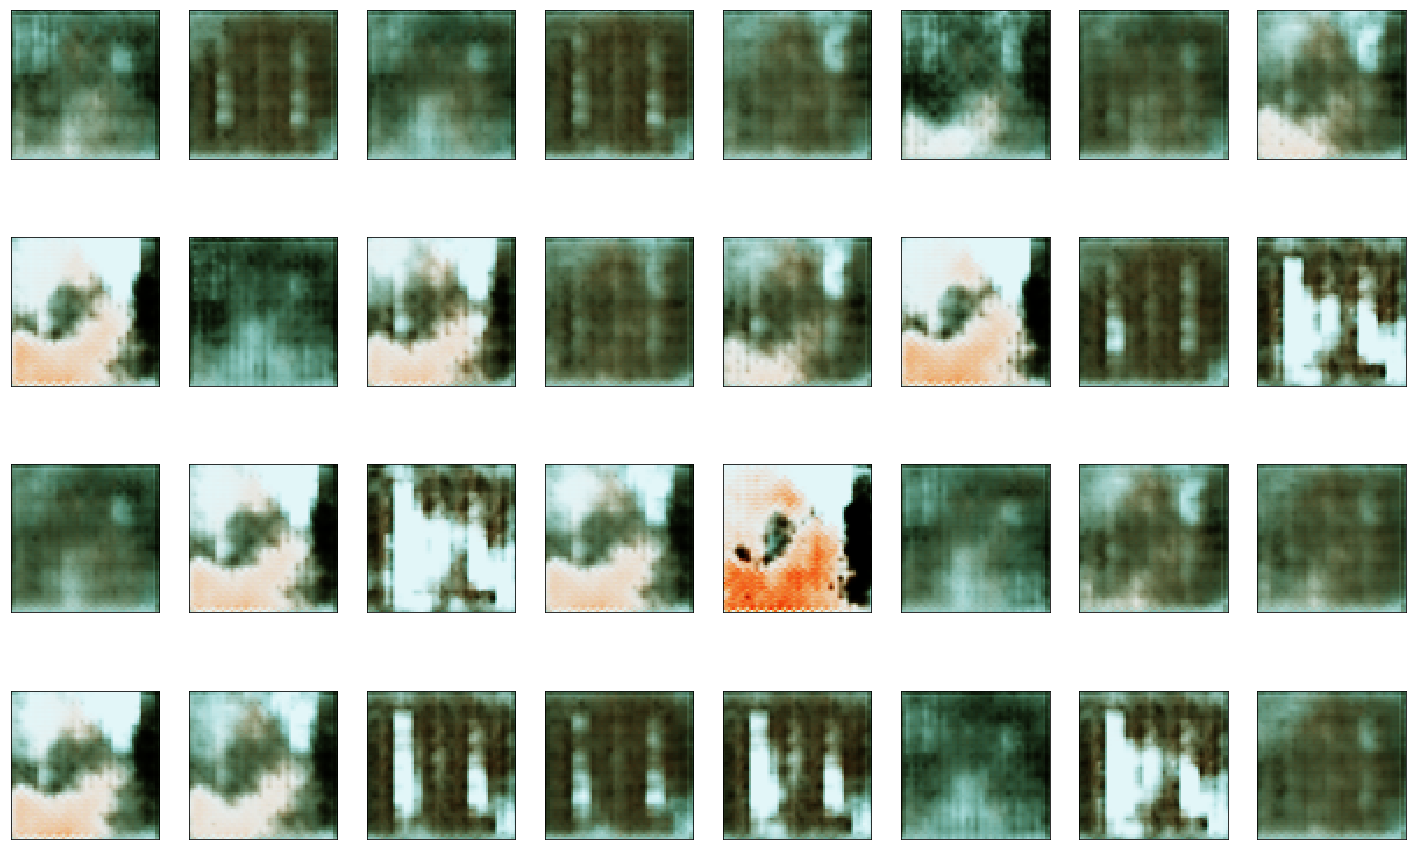

In [11]:
fig = plt.figure(figsize=(25, 16))
for i, j in enumerate(images[:32]):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    plt.imshow(j)

In [ ]:
shutil.make_archive('images', 'zip', OUT_DIR)

In [ ]:
elapsed_time = time.time() - start_time
print(f'All process done in {int(elapsed_time // 3600)} hours {int(elapsed_time % 3600 // 60)} min.')